In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from PIL import Image
import requests
from io import BytesIO

In [3]:
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

In [4]:
from adjustText import adjust_text

In [5]:
zion_id = find_players_by_full_name("Zion Williamson")[0]['id']

In [6]:
zion_shotchart = ShotChartDetail(team_id=0, player_id=zion_id, context_measure_simple='FGA')

In [7]:
zion_df = zion_shotchart.get_data_frames()[0]

In [8]:
zion_df.LOC_X = -zion_df.LOC_X

In [9]:
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220.25, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((219.75, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 469, linewidth=lw,
                            color=color, fill=None)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [10]:
text_location_mapping = {
    ('Right Corner 3', 'Right Side(R)', '24+ ft.'): (-235, 50),
    ('Left Corner 3', 'Left Side(L)', '24+ ft.'): (235, 50),
    ('Above the Break 3', 'Center(C)', '24+ ft.'): (0, 260),
    ('Above the Break 3', 'Left Side Center(LC)', '24+ ft.'): (155, 230),
    ('Above the Break 3', 'Right Side Center(RC)', '24+ ft.'): (-155, 230),
    ('Restricted Area', 'Center(C)', 'Less Than 8 ft.'): (0, 20),
    ('Mid-Range', 'Center(C)', '16-24 ft.'): (0, 190),
    ('Mid-Range', 'Center(C)', '8-16 ft.') : (0, 150),  # merge prethodni
    ('Mid-Range', 'Left Side Center(LC)', '16-24 ft.'): (110, 180),
    ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.'): (-110, 180),
    ('In The Paint (Non-RA)', 'Center(C)', '8-16 ft.'): (0, 110),
    ('In The Paint (Non-RA)', 'Center(C)', 'Less Than 8 ft.'): (0, 60),
    ('In The Paint (Non-RA)', 'Left Side(L)', '8-16 ft.'): (70, 80),  # merge s ovim dole
    ('Mid-Range', 'Left Side(L)', '8-16 ft.'): (120, 50),
    ('In The Paint (Non-RA)', 'Right Side(R)', '8-16 ft.'): (-70, 80),  # merge s ovim dole
    ('Mid-Range', 'Right Side(R)', '8-16 ft.'): (-120, 50),
    ('Mid-Range', 'Left Side(L)', '16-24 ft.'): (190, 50),
    ('Mid-Range', 'Right Side(R)', '16-24 ft.'): (-190, 50),
}

In [11]:
def plot_raw_shotchart(data_frame, title, mode="dark", assist_df=None, image_name=None):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12, 12))
    green = '#45B056'
    red = '#B04556'
    
    # ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.')
    """value = ('In The Paint (Non-RA)', 'Right Side(R)', '8-16 ft.')
    SHOT_ZONE_BASIC, SHOT_ZONE_AREA, SHOT_ZONE_RANGE = value

    data_frame = data_frame.loc[(data_frame.SHOT_ZONE_BASIC == SHOT_ZONE_BASIC) & (data_frame.SHOT_ZONE_AREA == SHOT_ZONE_AREA) & (data_frame.SHOT_ZONE_RANGE == SHOT_ZONE_RANGE)]
    """
    ('Backcourt', 'Back Court(BC)', 'Back Court Shot')
    data_frame = data_frame.loc[data_frame.SHOT_ZONE_BASIC != 'Backcourt']
    original_df = data_frame
    
    made_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 1]
    missed_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 0]
    
    paths = ax.scatter(
        x=made_shots.LOC_X,
        y=made_shots.LOC_Y,
        marker='o',
        c=green,
        s=180,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='Made Shots'
    )
    
    paths = ax.scatter(
        x=missed_shots.LOC_X,
        y=missed_shots.LOC_Y,
        marker='o',
        c=red,
        s=180,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='Missed Shots'
    )
    
    if mode == 'dark':
        background_color="#363F48"
        font_color="#E8E8FF"
    else:
        background_color="#EBEBE8"
        font_color = "#454545"
    
    """texts = []
    for index in range(len(data_frame)):
        item = data_frame.iloc[index]
        texts.append(plt.text(x=item.LOC_X, y=item.LOC_Y, s=item.ACTION_TYPE, fontsize=10, ha='center', va='center',
               bbox={'facecolor': '#EEEEEE', 'alpha': 0.75, 'edgecolor': 'black'}, zorder=0))
    """
    
    df_by_zone_sum = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
    df_by_zone_sum.loc[:, 'ZONE_PCT'] = (df_by_zone_sum.SHOT_MADE_FLAG / df_by_zone_sum.SHOT_ATTEMPTED_FLAG) * 100
    df_by_zone_median = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).median()
    for index in range(len(df_by_zone_median)):
        loc_x = df_by_zone_median.iloc[index].LOC_X
        loc_y = df_by_zone_median.iloc[index].LOC_Y
        zone_percentage = df_by_zone_sum.iloc[index].ZONE_PCT
        zone_shots_made = df_by_zone_sum.iloc[index].SHOT_MADE_FLAG
        zone_shots_attempted = df_by_zone_sum.iloc[index].SHOT_ATTEMPTED_FLAG
        x, y = text_location_mapping[df_by_zone_median.iloc[index].name]
        if zone_shots_attempted < 3:
            continue
        ax.text(x=x, y=y, s=f"{int(zone_shots_made)}/{int(zone_shots_attempted)}", ha='center', c='black',
               bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'})
    
    # Changing court color
    #ax.set_facecolor('#FFFAFA')
    # Legend
    ax.legend()

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    #ax.set_xticks(range(-250, 255, 10))
    #ax.set_xticklabels(range(-250, 255, 10), rotation=90)
    #ax.set_yticks(range(0, 300, 10))
    #ax.set_yticklabels(range(0, 300, 10))
    ax.grid(False)
    
    team_id = made_shots.iloc[0].TEAM_ID
    player_id = made_shots.iloc[0].PLAYER_ID
    url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2019/260x190/{player_id}.png"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    ax.imshow(img, extent=(132, 252, -48, 40))
    
    # Title
    plt.title(title, size=20)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, background_color=background_color)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)
    
    #adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k'), expand_points=(1.25, 1.25), expand_text=(1.25, 1.25), force_text=(0.5, 0.9))
    
    if image_name:
        fig.savefig(image_name, bbox_inches='tight')

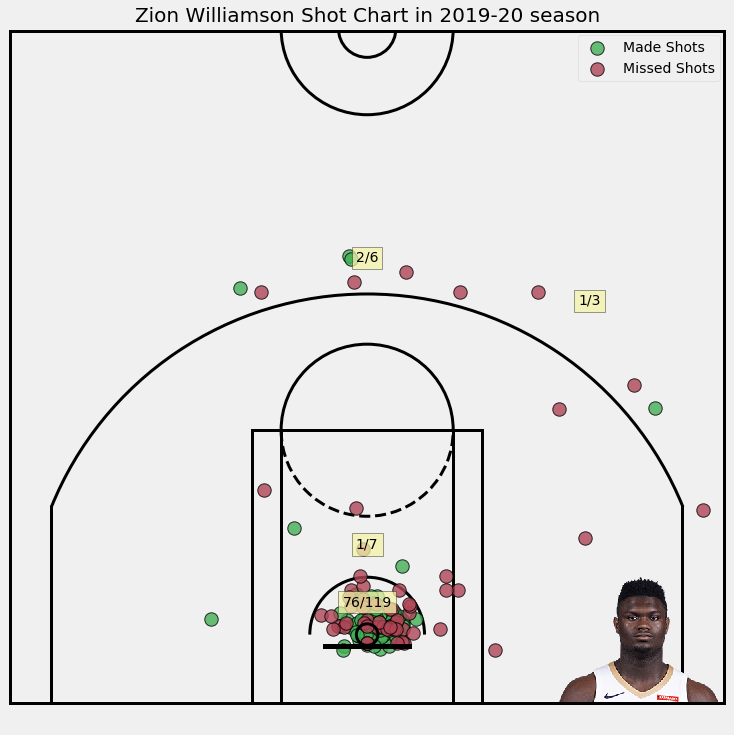

In [12]:
plot_raw_shotchart(zion_df, title="Zion Williamson Shot Chart in 2019-20 season", mode='light')

In [13]:
find_players_by_full_name("Zion Williamson")

[{'id': 1629627,
  'full_name': 'Zion Williamson',
  'first_name': 'Zion',
  'last_name': 'Williamson',
  'is_active': True}]

# Next Level Rebounding

In [14]:
from nba_api.stats.endpoints.leaguedashplayerbiostats import LeagueDashPlayerBioStats

In [15]:
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats

In [16]:
league_bio = LeagueDashPlayerBioStats()

In [17]:
league_df = league_bio.get_data_frames()[0]

In [18]:
league_df.loc[:, 'PLAYER_HEIGHT_CM'] = league_df.PLAYER_HEIGHT_INCHES * 2.54

In [19]:
rebounding_stats = LeagueDashPtStats(pt_measure_type='Rebounding', per_mode_simple='PerGame', player_or_team='Player')

In [20]:
rebounding_df = rebounding_stats.get_data_frames()[0]

In [21]:
merged_df = pd.merge(left=rebounding_df, right=league_df, on='PLAYER_ID')

In [22]:
offs = merged_df.loc[merged_df.OREB > 0.2]

In [23]:
zion = offs.loc[offs.PLAYER_ID == zion_id]

In [24]:
other = offs.loc[offs.PLAYER_ID != zion_id]

In [25]:
top_10 = other.sort_values(by='OREB', ascending=False).iloc[:10]
small_guy = other.loc[(other.OREB > 2) & (other.PLAYER_HEIGHT_CM < 203)]

128

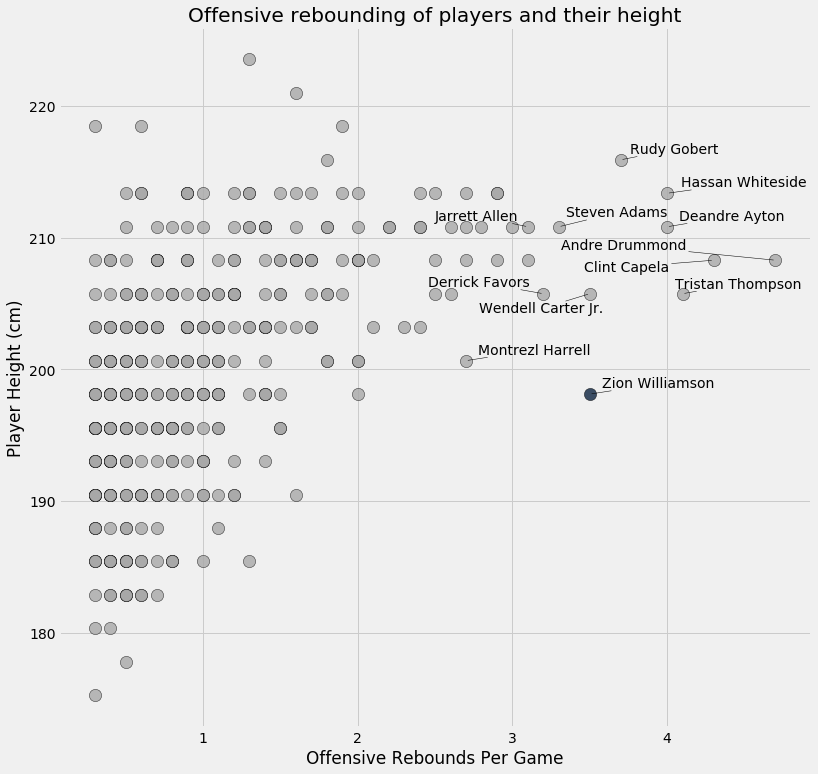

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(x=other.OREB, y=other.PLAYER_HEIGHT_CM, s=150, edgecolors='black', alpha=0.8, color='#A8A8A8')
ax.scatter(x=zion.OREB, y=zion.PLAYER_HEIGHT_CM, s=150, edgecolors='black', alpha=0.8, color='#0C2340')
ax.set_xlabel("Offensive Rebounds Per Game")
ax.set_ylabel("Player Height (cm)")
ax.set_title("Offensive rebounding of players and their height")

texts = [ax.text(x=zion.iloc[0].OREB, y=zion.iloc[0].PLAYER_HEIGHT_CM, s="Zion Williamson")]
added = ['Zion Williamson']
for index in range(len(top_10)):
    item = top_10.iloc[index]
    if item.PLAYER_NAME_x not in added:
        texts.append(ax.text(x=item.OREB, y=item.PLAYER_HEIGHT_CM, s=item.PLAYER_NAME_x))
        added.append(item.PLAYER_NAME_x)

for index in range(len(small_guy)):
    item = small_guy.iloc[index]
    if item.PLAYER_NAME_x not in added:
        texts.append(ax.text(x=item.OREB, y=item.PLAYER_HEIGHT_CM, s=item.PLAYER_NAME_x))
        added.append(item.PLAYER_NAME_x)

adjust_text(texts, expand_points=(1.2, 1.4), force_points=(1.1, 1.3), arrowprops=dict(arrowstyle="-", color='k'))

128

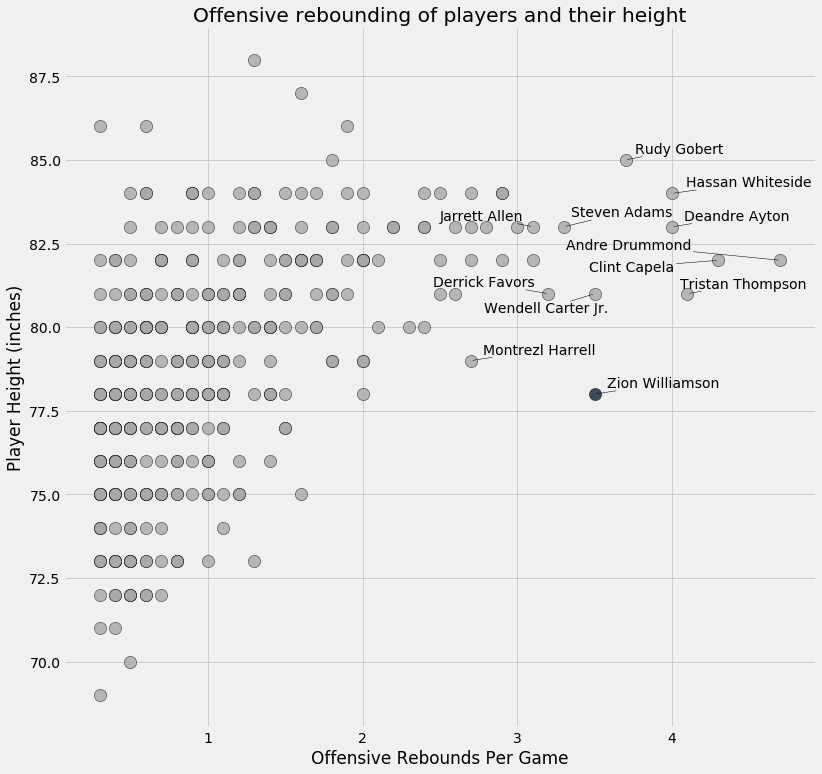

In [29]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(x=other.OREB, y=other.PLAYER_HEIGHT_INCHES, s=150, edgecolors='black', alpha=0.8, color='#A8A8A8')
ax.scatter(x=zion.OREB, y=zion.PLAYER_HEIGHT_INCHES, s=150, edgecolors='black', alpha=0.8, color='#0C2340')
ax.set_xlabel("Offensive Rebounds Per Game")
ax.set_ylabel("Player Height (inches)")
ax.set_title("Offensive rebounding of players and their height")

texts = [ax.text(x=zion.iloc[0].OREB, y=zion.iloc[0].PLAYER_HEIGHT_INCHES, s="Zion Williamson")]
added = ['Zion Williamson']
for index in range(len(top_10)):
    item = top_10.iloc[index]
    if item.PLAYER_NAME_x not in added:
        texts.append(ax.text(x=item.OREB, y=item.PLAYER_HEIGHT_INCHES, s=item.PLAYER_NAME_x))
        added.append(item.PLAYER_NAME_x)

for index in range(len(small_guy)):
    item = small_guy.iloc[index]
    if item.PLAYER_NAME_x not in added:
        texts.append(ax.text(x=item.OREB, y=item.PLAYER_HEIGHT_INCHES, s=item.PLAYER_NAME_x))
        added.append(item.PLAYER_NAME_x)

adjust_text(texts, expand_points=(1.2, 1.4), force_points=(1.1, 1.3), arrowprops=dict(arrowstyle="-", color='k'))

# Off vs Def rebs

In [27]:
off_rebounders = other.loc[(other.OREB > other.DREB * 0.6) & (other.OREB > 2)]

2

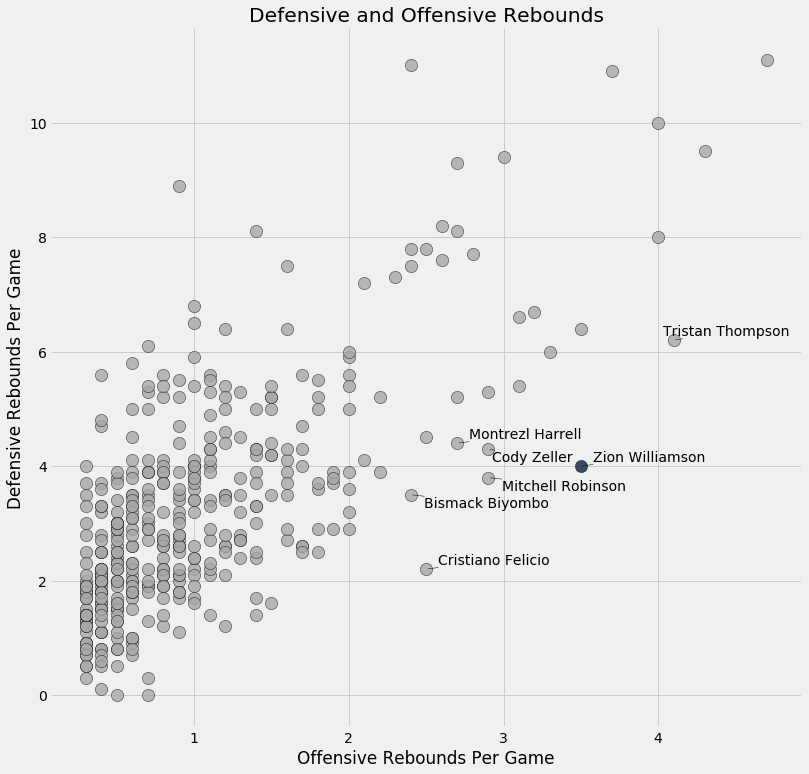

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(x=other.OREB, y=other.DREB, s=150, edgecolors='black', alpha=0.8, color='#A8A8A8')
ax.scatter(x=zion.OREB, y=zion.DREB, s=150, edgecolors='black', alpha=0.8, color='#0C2340')
ax.set_xlabel("Offensive Rebounds Per Game")
ax.set_ylabel("Defensive Rebounds Per Game")
ax.set_title("Defensive and Offensive Rebounds")


texts = [ax.text(x=zion.iloc[0].OREB, y=zion.iloc[0].DREB, s="Zion Williamson")]
added = []
for index in range(len(off_rebounders)):
    item = off_rebounders.iloc[index]
    if item.PLAYER_NAME_x not in added:
        texts.append(ax.text(x=item.OREB, y=item.DREB, s=item.PLAYER_NAME_x))
        added.append(item.PLAYER_NAME_x)

adjust_text(texts, expand_points=(1.2, 1.2),force_points=(1.1, 1.3), arrowprops=dict(arrowstyle="-", color='k'))

# Shot Selection

In [29]:
from nba_api.stats.endpoints.leaguedashplayershotlocations import LeagueDashPlayerShotLocations

In [30]:
shot_locations = LeagueDashPlayerShotLocations(per_mode_detailed='PerGame')

In [31]:
locations_dict = shot_locations.get_dict()

In [32]:
locations = ['Restricted_Area', 'Paint_non_RA', 'Mid_Range', 'Left_Corner3', 'Right_Corner3', 'Above_the_Break3', 'Backourt']

In [33]:
columns = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE']
for location in locations:
    columns.append(f'FGM_{location}')
    columns.append(f'FGA_{location}')
    columns.append(f'FG_PCT_{location}')

In [34]:
shot_loc_df = pd.DataFrame(data=locations_dict['resultSets']['rowSet'], columns=columns)

In [35]:
shot_loc_df = shot_loc_df.loc[shot_loc_df.FGA_Restricted_Area > 4].sort_values(by='FGA_Restricted_Area', ascending=False).iloc[:40]

In [36]:
zion_loc = shot_loc_df.loc[shot_loc_df.PLAYER_ID == zion_id]
non_zion_loc = shot_loc_df.loc[shot_loc_df.PLAYER_ID != zion_id]

In [37]:
zion_item = zion_loc.iloc[0]

In [38]:
top_non_zion = non_zion_loc.iloc[:4]
other_non_zion = non_zion_loc.iloc[4:]

In [39]:
colors = ['#00471B', '#CE1141', '#000000', '#006BB6', '#552583']

Text(0.5, 1.0, 'FGA per Game based on Shot Locations')

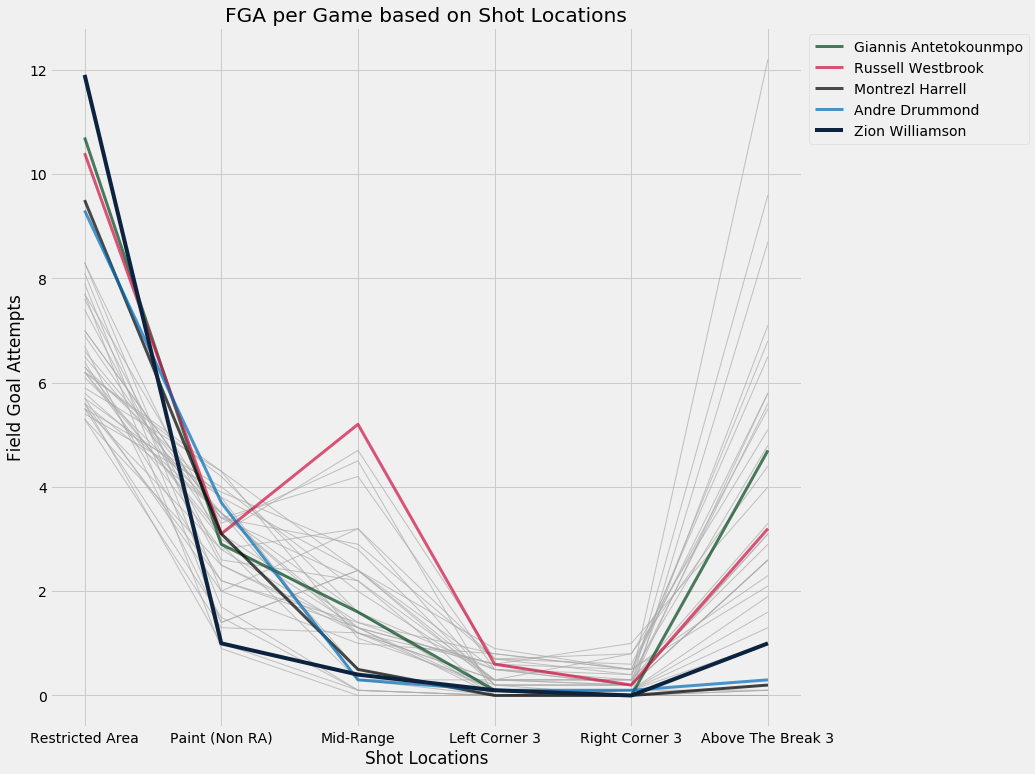

In [40]:
fig, ax = plt.subplots(figsize=(12, 12))

for index in range(len(other_non_zion)):
    item = other_non_zion.iloc[index]
    ax.plot([
        item.FGA_Restricted_Area,
        item.FGA_Paint_non_RA,
        item.FGA_Mid_Range,
        item.FGA_Left_Corner3,
        item.FGA_Right_Corner3,
        item.FGA_Above_the_Break3
    ], color='#AAAAAA', alpha=0.7, lw=1)
    
for index in range(len(top_non_zion)):
    item = top_non_zion.iloc[index]
    ax.plot([
        item.FGA_Restricted_Area,
        item.FGA_Paint_non_RA,
        item.FGA_Mid_Range,
        item.FGA_Left_Corner3,
        item.FGA_Right_Corner3,
        item.FGA_Above_the_Break3
    ], color=colors[index], alpha=0.7, lw=3, label=item.PLAYER_NAME)
    
ax.plot([
    zion_item.FGA_Restricted_Area,
    zion_item.FGA_Paint_non_RA,
    zion_item.FGA_Mid_Range,
    zion_item.FGA_Left_Corner3,
    zion_item.FGA_Right_Corner3,
    zion_item.FGA_Above_the_Break3
], color='#0C2340', lw=4, label=zion_item.PLAYER_NAME)

ax.set_xticklabels(['', 'Restricted Area', 'Paint (Non RA)', 'Mid-Range', 'Left Corner 3', 'Right Corner 3', 'Above The Break 3'])
ax.legend(loc='upper left', bbox_to_anchor=(1., 1))
ax.set_xlabel("Shot Locations")
ax.set_ylabel("Field Goal Attempts")
ax.set_title("FGA per Game based on Shot Locations")